In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import itertools
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns
import shap 
sns.set_style('darkgrid')

# Define file paths

In [128]:
MEASURES_FILE = "MdRQA_measures.csv"
SHUFF_MEASURES_FILE = "shuff_MdRQA_measures.csv"
LABELS_FILE = "team_block_outcomes.csv"


# Load data

In [129]:
dfMeasures = pd.read_csv(MEASURES_FILE)
dfShuffMeasures = pd.read_csv(SHUFF_MEASURES_FILE)
dfLabels = pd.read_csv(LABELS_FILE)


# dfTaskScore = dfLabels.loc[:, ['GROUPID', 'block', 'task_score']]
# dfSubjectiveOutcomes = dfLabels.loc[:, ['GROUPID', 'block', 'CPS_and_ITN_mean']]
# dfValence = dfLabels.loc[:, ['GROUPID', 'block', 'Valence']]

print("%s shape: %s" % (MEASURES_FILE, dfMeasures.shape))
print("%s shape: %s" % (SHUFF_MEASURES_FILE, dfShuffMeasures.shape))
print("%s shape: %s" % (LABELS_FILE, dfLabels.shape))


MdRQA_measures.csv shape: (271, 11)
shuff_MdRQA_measures.csv shape: (271, 11)
team_block_outcomes.csv shape: (274, 7)


In [137]:
display(dfShuffMeasures.isnull().any())
display(dfShuffMeasures[dfShuffMeasures['ADL'].isna()])
display(dfShuffMeasures[dfShuffMeasures['ADL'].isna()])



GROUPID    False
block      False
REC        False
DET        False
ADL         True
MDL        False
DENTR      False
LAM        False
AVL         True
MVL        False
VENTR      False
dtype: bool

,GROUPID,block,REC,DET,ADL,MDL,DENTR,LAM,AVL,MVL,VENTR
29,1035,ExpBlock2,0.036747,0.0,NaN,1,0.0,0.364446,2.0,2,2.890372
235,2053,ExpBlock1,0.058852,0.0,NaN,1,0.0,0.000000,NaN,1,0.000000


,GROUPID,block,REC,DET,ADL,MDL,DENTR,LAM,AVL,MVL,VENTR
29,1035,ExpBlock2,0.036747,0.0,NaN,1,0.0,0.364446,2.0,2,2.890372
235,2053,ExpBlock1,0.058852,0.0,NaN,1,0.0,0.000000,NaN,1,0.000000


# Experiment Set Up

In [138]:
# Get model type
shuffled = False
num_iters = 3
num_folds = 5

if shuffled:
    dfData = pd.merge(dfShuffMeasures, dfLabels, on=['GROUPID', 'block'], how='inner')
else:
    dfData = pd.merge(dfMeasures, dfLabels, on=['GROUPID', 'block'], how='inner')

print("dfData shape: ", dfData.shape)
dfData

dfData shape:  (271, 16)


,GROUPID,block,REC,DET,ADL,MDL,DENTR,LAM,AVL,MVL,VENTR,CPS_and_ITN_mean,Valence,num_gold,num_silver,task_score
0,1010,ExpBlock1,0.111890,46.765002,2.580148,12,8.031479,63.476117,3.202765,8,8.276899,-0.304697,3.666667,1.0,1.0,3.0
1,1010,ExpBlock2,0.221818,51.941830,2.801763,13,8.693110,71.437617,3.567544,14,8.801583,-0.304697,3.666667,2.0,1.0,5.0
2,10100,ExpBlock1,0.469005,68.603876,3.236574,27,9.502080,83.376781,4.480822,28,9.315484,0.486795,4.000000,0.0,0.0,0.0
3,10100,ExpBlock2,0.328632,63.319890,3.373809,34,8.995863,78.390610,4.336822,35,8.899755,0.545526,4.666667,0.0,3.0,3.0
4,10102,ExpBlock1,0.275806,40.010880,2.781595,16,8.650819,60.603101,3.351069,15,8.895810,0.454631,4.333333,3.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,2070,ExpBlock2,0.128570,35.135661,2.392715,9,7.967704,59.342180,2.886733,9,8.447403,0.302205,4.000000,0.0,4.0,4.0
267,2070,Warmup,0.411115,49.651775,2.839304,42,9.178902,70.710415,3.726037,43,9.143787,0.489594,4.000000,3.0,0.0,6.0
268,2071,ExpBlock1,0.291773,45.826191,2.544979,11,8.971522,68.343464,3.244426,12,9.145826,0.032318,2.333333,0.0,0.0,0.0
269,2071,ExpBlock2,0.188310,46.079278,2.572276,16,8.522221,66.710627,3.169010,17,8.746838,0.117616,4.333333,1.0,4.0,6.0


## Prep for team-level cross validation

In [139]:
# Define fold names
train_folds = []
test_folds = []
set_type = "test"
for i in range(1,num_folds+1): 
    col_name = "Fold" + str(i) + "_" + set_type
    test_folds.append(col_name)
    set_type = "train"  
    col_name = "Fold" + str(i) + "_" + set_type
    train_folds.append(col_name)
    set_type = "test"

print("Train fold names: ", train_folds)
print("Test fold names: ",test_folds)


folds_dict_list = []

# Split teams into 5 groups
teams = pd.unique(dfMeasures.GROUPID)

for j in range(num_iters):
    print("\nIteration: ", j+1)
    random.Random(j).shuffle(teams)
    groups = np.array_split(teams, 5)
    
    # Define groups for each fold
    fold_groups = {}
    for i, (train_fold, test_fold) in enumerate(zip(train_folds, test_folds)):
        # make the current group the test group
        fold_groups[test_fold] = groups[i]
        # make all other groups the train group
        train_group = groups[:i] + groups[i+1:]
        train_group = [team for group in train_group for team in group]
        fold_groups[train_fold] = train_group
        
    ## Confirm that for each fold, there is no team overlap bewteen train and test set
    for i in range(1,num_folds+1):
        assert set(fold_groups['Fold'+str(i)+'_test']).isdisjoint(set(fold_groups['Fold'+str(i)+'_train'])), "There is overlap in train and test set " + str(i)
    
    print("* No team overlap *")
    
    # Add fold groups to dictionary
    folds_dict_list.append(fold_groups)

# Informational
print("\nNumber of iterations: ", len(folds_dict_list))
# for fold_groups in folds_dict_list:
#     for key in fold_groups:
#         print("\n", key)
#         print(fold_groups[key])
#         print("Num groups: ", len(fold_groups[key]))
    
    

Train fold names:  ['Fold1_train', 'Fold2_train', 'Fold3_train', 'Fold4_train', 'Fold5_train']
Test fold names:  ['Fold1_test', 'Fold2_test', 'Fold3_test', 'Fold4_test', 'Fold5_test']

Iteration:  1
* No team overlap *

Iteration:  2
* No team overlap *

Iteration:  3
* No team overlap *

Number of iterations:  3


In [140]:
features = ['REC', 'DET', 'ADL', 'MDL', 'DENTR', 'LAM', 'AVL', 'MVL', 'VENTR']

def get_group_data(dfData, GROUPID_list, features_list, label_name):
    dfGroupsData = pd.DataFrame()    
    for GROUPID in GROUPID_list:
        dfGroupsData = pd.concat([dfGroupsData, dfData.loc[dfData['GROUPID'] == GROUPID, :]], ignore_index=True)
        
    data = dfGroupsData.loc[:, features_list]  
    labels = dfGroupsData.loc[:, label_name]

    return [data, labels, dfGroupsData]


# Predict Task Score


Iteration:  1
	Fold:  1
	Fold:  2
	Fold:  3
	Fold:  4
	Fold:  5
MAE:  1.38
MSE:  4.32
RMSE:  2.08
MAE from df:  1.38

Iteration:  2
	Fold:  1
	Fold:  2
	Fold:  3
	Fold:  4
	Fold:  5
MAE:  1.43
MSE:  4.47
RMSE:  2.11
MAE from df:  1.43

Iteration:  3
	Fold:  1
	Fold:  2
	Fold:  3
	Fold:  4
	Fold:  5
MAE:  2.58
MSE:  10.79
RMSE:  3.28
MAE from df:  2.58


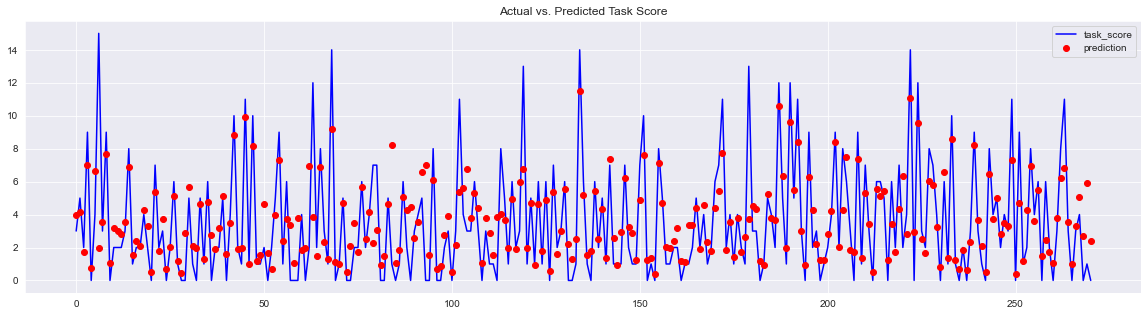

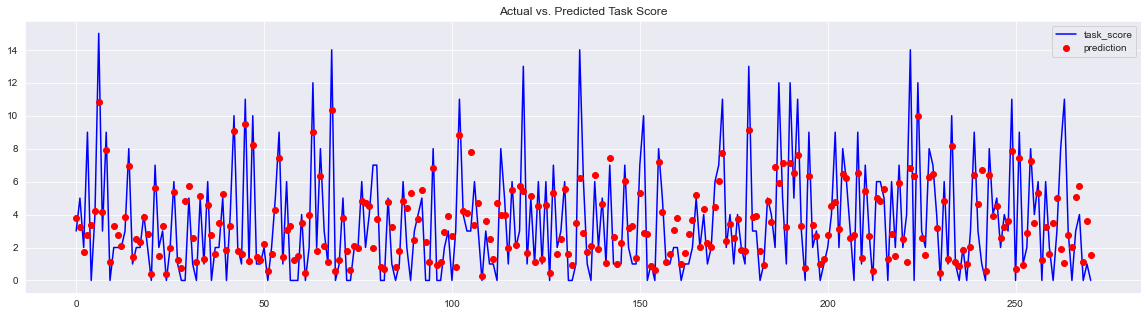

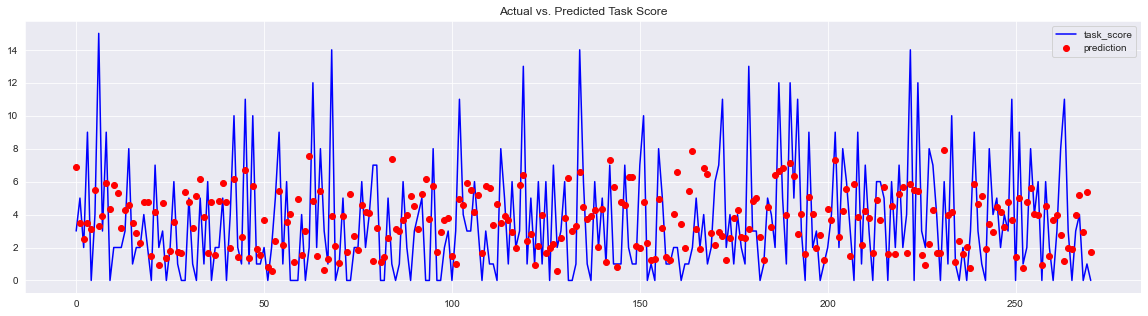

In [141]:
# Resources
## https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Store metrics for all iterations
# aurocs = []
maes = []    # MAE (mean absolute errors)
mses = []    # MSE (mean squared errors)
rmses = []   # RMSE (root mean squared errors)

all_y_test_task_score = [[] for i in range(num_iters)]
predictions_task_score = [[] for i in range(num_iters)]

# Store feature importances and std dev for all iterations
impurity_importances_task_score = pd.DataFrame(columns=features)
importances_std_task_score = pd.DataFrame(columns=features)

# For storing shap values across all folds
task_score_shap_values_0 = None
task_score_shap_values_1 = None
task_score_full_X_test = pd.DataFrame()

#-----------------------------------------------#
#      5-fold team level cross-validation       #
#-----------------------------------------------#

# For each iteration 
for i in range(num_iters):
    print("\nIteration: ", i+1)
    
    # Lists for cumulative test set and predictions for iteration
    dfFullTest = pd.DataFrame()
    all_y_test = []
    predictions = []
    
    # Create RandomForestClassifier for task_score prediction - DO WE NEED TO DO ANY BALANCING?
    rfc_task_score = RandomForestRegressor(n_estimators=100, random_state=1, \
                                           max_features='sqrt') 
    
    # Get fold groups
    fold_groups = folds_dict_list[i]
    
    # For each fold
    for j, (test_fold, train_fold) in enumerate(zip(test_folds, train_folds)):
        print("\tFold: ", j+1)
        # Get data for teams in test set
        test_data_list = get_group_data(dfData, fold_groups[test_fold], features, 'task_score')
        X_test = test_data_list[0]
        y_test = test_data_list[1]
        all_y_test.extend(y_test.tolist())
        dfFullTest = pd.concat([dfFullTest, test_data_list[2]], ignore_index=True)
        
        # Get data for teams in train set
        train_data_list = get_group_data(dfData, fold_groups[train_fold], features, 'task_score')
        X_train = train_data_list[0]
        y_train = train_data_list[1]
        

        # Train model
        rfc_task_score.fit(X_train, y_train)

        # Test model
        y_pred = rfc_task_score.predict(X_test)
        predictions.extend(y_pred.tolist())
        
#         ## Get SHAP values
#         explainer = shap.TreeExplainer(rfc_task_score)
#         shap_values = explainer.shap_values(X_test)
        
#         if j==0:
#             task_score_shap_values_0 = shap_values[0]
#             task_score_shap_values_1 = shap_values[1]
#         else:
#             task_score_shap_values_0 = np.vstack([task_score_shap_values_0, shap_values[0]])
#             task_score_shap_values_1 = np.vstack([task_score_shap_values_1, shap_values[1]])

            
#         task_score_full_X_test = pd.concat([task_score_full_X_test, X_test], ignore_index=True)
#         ## End of get SHAP values

# ----- END OF FOLDS

    # Calculate the absolute errors (MAE) of the iteration
    predictions = np.array(predictions)
    all_y_test = np.array(all_y_test)
    mae = metrics.mean_absolute_error(all_y_test, predictions)
    mse = metrics.mean_squared_error(all_y_test, predictions)
    rmse = np.sqrt(metrics.mean_squared_error(all_y_test, predictions))
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
    print('MAE: ', round(mae, 2))
    print('MSE: ', round(mse, 2))
    print('RMSE: ', round(rmse, 2))    
    
    # Save iteration task score truth labels, and predictions for stats across all iterations
    all_y_test_task_score[i] = all_y_test
    predictions_task_score[i] = predictions


    ### Compute Feature Importances for iteration ###
    # Impurity-based importances
    importances = rfc_task_score.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfc_task_score.estimators_], axis=0)
    imps = pd.Series(importances, index=features)
    stds = pd.Series(std, index=features)
    impurity_importances_task_score = pd.concat([impurity_importances_task_score, imps], ignore_index=True)
    importances_std_task_score = pd.concat([importances_std_task_score, stds], ignore_index=True)
    
#     ## Plot feature importances
#     fig1, ax1 = plt.subplots()
#     imps.plot.bar(yerr=std, ax=ax1)
#     ax1.set_title("Task Score Feature importances using MDI")
#     ax1.set_ylabel("Mean decrease in impurity")
#     plt.show()
#     ## END plotting feature importances

    ## FOR PLOTTING ACTUAL vs. PREDICTED   
    dfTruevPred = dfFullTest.loc[:, ['GROUPID', 'block', 'task_score']]
    dfTruevPred['prediction'] = predictions
    dfTruevPred.sort_values(['GROUPID', 'block', 'task_score'], ignore_index=True, inplace=True)
    dfTruevPred['error'] = abs(dfTruevPred['prediction'] - dfTruevPred['task_score'])
    print("MAE from df: ", round(np.mean(dfTruevPred['error']), 2))
    dfTruevPred.plot(y=['task_score', 'prediction'], title='Actual vs. Predicted Task Score', \
                     style=['b-', 'ro'], figsize=(20, 5))
    ## END PLOTTING
    
# ----- END OF ITERATIONS

    
# # Get mean AUROC over all iterations
# avg_auroc = np.mean(aurocs)
# print("Mean AUROC over %d iterations: %f" % (i+1, avg_auroc))

# # Get median AUROC over all iterations
# med_auroc = np.median(aurocs)
# task_score_med_auroc_idx = np.argsort(aurocs)[len(aurocs)//2]
# print("Median AUROC over %d iterations: %f" % (i+1, med_auroc))
# print("Median iteration number: ", task_score_med_auroc_idx+1)
# print("All AUROCS: ", aurocs)

# # Save median iteration labels and predictions
# med_y_test_task_score = all_y_test_task_score[task_score_med_auroc_idx]
# med_predictions_task_score = predictions_task_score[task_score_med_auroc_idx]
# # med_test_indices_COMM = all_test_indices_COMM[COMM_med_auroc_idx]    

In [142]:
dfTruevPred

,GROUPID,block,task_score,prediction,error
0,1010,ExpBlock1,3.0,6.91,3.91
1,1010,ExpBlock2,5.0,3.49,1.51
2,1020,ExpBlock1,2.0,2.50,0.50
3,1020,ExpBlock2,9.0,3.50,5.50
4,1020,Warmup,0.0,3.15,3.15
...,...,...,...,...,...
266,10103,ExpBlock2,3.0,4.00,1.00
267,10103,Warmup,4.0,5.17,1.17
268,10104,ExpBlock1,0.0,2.97,2.97
269,10104,ExpBlock2,1.0,5.34,4.34


In [100]:
dfTruevPred

,GROUPID,block,task_score,prediction,error
0,1010,ExpBlock1,3.0,4.88,1.88
1,1010,ExpBlock2,5.0,4.26,0.74
2,1020,ExpBlock1,2.0,2.67,0.67
3,1020,ExpBlock2,9.0,8.43,0.57
4,1020,Warmup,0.0,4.74,4.74
...,...,...,...,...,...
266,10103,ExpBlock2,3.0,4.14,1.14
267,10103,Warmup,4.0,3.13,0.87
268,10104,ExpBlock1,0.0,3.43,3.43
269,10104,ExpBlock2,1.0,2.57,1.57
